In [15]:
import gzip
import pickle
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import graphviz
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

pd.options.display.max_columns = None

## Functions

In [2]:
def create_dataframe_list(paths):
    dataframe_list = []
    for path in paths:
        data = pd.read_pickle(path)
        
        # Retrieve Datas
        # Multiple Datas
        rpeaks = data['rpeaks']
        signal_chest_ACC = data['signal']['chest']['ACC']   # 700Hz + 3 dimensions
        signal_chest_ECG = data['signal']['chest']['ECG']   # 700Hz
        signal_chest_resp = data['signal']['chest']['Resp'] # 700Hz
        signal_wrist_ACC = data['signal']['wrist']['ACC']   # 32Hz + 3 dimensions
        signal_wrist_BVP = data['signal']['wrist']['BVP']   # 64Hz
        signal_wrist_EDA = data['signal']['wrist']['EDA']   # 4Hz
        signal_wrist_TEMP = data['signal']['wrist']['TEMP'] # 4Hz
        activity = data['activity']                         # 4Hz
        label = data['label']
        
        # Unique Datas
        weight = data['questionnaire']['WEIGHT']
        gender = data['questionnaire']['Gender']
        age = data['questionnaire']['AGE']
        height = data['questionnaire']['HEIGHT']
        skin = data['questionnaire']['SKIN']
        sport = data['questionnaire']['SPORT']
        subject = data['subject']
        elapsed_time = len(activity)/4
        
        # Deal with rpeaks
        rpeaks_per_second_4Hz = make_rpeaks_perSecond_4Hz(rpeaks, elapsed_time)
        
        # Attribute weights on rpeaks values
        rpeaks_per_second_4Hz_weight = rpeaks_weight(rpeaks_per_second_4Hz)
        
        # Pass everything to 4Hz
        signal_chest_ACC_4Hz = signal_chest_ACC[::175]    # 3 dimensions
        signal_chest_ECG_4Hz = signal_chest_ECG[::175]
        signal_chest_resp_4Hz = signal_chest_resp[::175]
        signal_wrist_ACC_4Hz = signal_wrist_ACC[::8]      # 3 dimensions
        signal_wrist_BVP_4Hz = signal_wrist_BVP[::16]
        
        # Split variables in 3 dimensions
        signal_chest_ACC_4Hz_X = []
        signal_chest_ACC_4Hz_Y = []
        signal_chest_ACC_4Hz_Z = []
        for tab in signal_chest_ACC_4Hz:
            signal_chest_ACC_4Hz_X.append(tab[0])
            signal_chest_ACC_4Hz_Y.append(tab[1])
            signal_chest_ACC_4Hz_Z.append(tab[2])
            
        signal_wrist_ACC_4Hz_X = []
        signal_wrist_ACC_4Hz_Y = []
        signal_wrist_ACC_4Hz_Z = []
        for tab in signal_wrist_ACC_4Hz:
            signal_wrist_ACC_4Hz_X.append(tab[0])
            signal_wrist_ACC_4Hz_Y.append(tab[1])
            signal_wrist_ACC_4Hz_Z.append(tab[2])
            
        # Extract Values
        signal_chest_ECG_4Hz_ = []
        signal_chest_resp_4Hz_ = []
        signal_wrist_BVP_4Hz_ = []
        signal_wrist_EDA_ = []
        signal_wrist_TEMP_ = []
        activity_ = []
        for x in range(len(signal_chest_ECG_4Hz)) : 
            signal_chest_ECG_4Hz_.append(signal_chest_ECG_4Hz[x][0])
            signal_chest_resp_4Hz_.append(signal_chest_resp_4Hz[x][0])
            signal_wrist_BVP_4Hz_.append(signal_wrist_BVP_4Hz[x][0])
            signal_wrist_EDA_.append(signal_wrist_EDA[x][0])
            signal_wrist_TEMP_.append(signal_wrist_TEMP[x][0])
            activity_.append(int(activity[x][0]))
            
        SUM_chest_ACC_X = []
        SUM_chest_ACC_Y = []
        SUM_chest_ACC_Z = []
        SUM_wrist_ACC_X = []
        SUM_wrist_ACC_Y = []
        SUM_wrist_ACC_Z = []
        
        for i in range(len(activity)):
            if i == 0:
                SUM_chest_ACC_X.append(abs(signal_chest_ACC_4Hz_X[i]))
                SUM_chest_ACC_Y.append(abs(signal_chest_ACC_4Hz_Y[i]))
                SUM_chest_ACC_Z.append(abs(signal_chest_ACC_4Hz_Z[i]))
                SUM_wrist_ACC_X.append(abs(signal_wrist_ACC_4Hz_X[i]))
                SUM_wrist_ACC_Y.append(abs(signal_wrist_ACC_4Hz_Y[i]))
                SUM_wrist_ACC_Z.append(abs(signal_wrist_ACC_4Hz_Z[i]))
            else:
                SUM_chest_ACC_X.append(abs(SUM_chest_ACC_X[i-1]) + abs(signal_chest_ACC_4Hz_X[i]-signal_chest_ACC_4Hz_X[i-1]))
                SUM_chest_ACC_Y.append(abs(SUM_chest_ACC_Y[i-1]) + abs(signal_chest_ACC_4Hz_Y[i]-signal_chest_ACC_4Hz_Y[i-1]))
                SUM_chest_ACC_Z.append(abs(SUM_chest_ACC_Z[i-1]) + abs(signal_chest_ACC_4Hz_Z[i]-signal_chest_ACC_4Hz_Z[i-1]))
                SUM_wrist_ACC_X.append(abs(SUM_wrist_ACC_X[i-1]) + abs(signal_wrist_ACC_4Hz_X[i]-signal_wrist_ACC_4Hz_X[i-1]))
                SUM_wrist_ACC_Y.append(abs(SUM_wrist_ACC_Y[i-1]) + abs(signal_wrist_ACC_4Hz_Y[i]-signal_wrist_ACC_4Hz_Y[i-1]))
                SUM_wrist_ACC_Z.append(abs(SUM_wrist_ACC_Z[i-1]) + abs(signal_wrist_ACC_4Hz_Z[i]-signal_wrist_ACC_4Hz_Z[i-1]))
            
        ## Get index of every step
        #index_A1 = [index for index in range(len(activity)) if int(activity[index, 0]) == 1]
        #index_A2 = [index for index in range(len(activity)) if int(activity[index, 0]) == 2]
        #index_A3 = [index for index in range(len(activity)) if int(activity[index, 0]) == 3]
        #index_A4 = [index for index in range(len(activity)) if int(activity[index, 0]) == 4]
        #index_A5 = [index for index in range(len(activity)) if int(activity[index, 0]) == 5]
        #index_A6 = [index for index in range(len(activity)) if int(activity[index, 0]) == 6]
        #index_A7 = [index for index in range(len(activity)) if int(activity[index, 0]) == 7]
        #index_A8 = [index for index in range(len(activity)) if int(activity[index, 0]) == 8]
        #
        #index_A0_0 = list(range(0, index_A1[0]-1))
        #index_A0_1 = list(range(index_A1[len(index_A1)-1]+1, index_A2[0]-1))
        #index_A0_2 = list(range(index_A2[len(index_A2)-1]+1, index_A3[0]-1))
        #index_A0_3 = list(range(index_A3[len(index_A3)-1]+1, index_A4[0]-1))
        #index_A0_4 = list(range(index_A4[len(index_A4)-1]+1, index_A5[0]-1))
        #index_A0_5 = list(range(index_A5[len(index_A5)-1]+1, index_A6[0]-1))
        #index_A0_6 = list(range(index_A6[len(index_A6)-1]+1, index_A7[0]-1))
        #index_A0_7 = list(range(index_A7[len(index_A7)-1]+1, index_A8[0]-1))
        #index_A0_8 = list(range(index_A8[len(index_A8)-1]+1, len(activity)-1))
        #
        ## Get duration of every step
        #time_A0_0 = index_A0_0[-1]/4
        #time_A0_1 = (index_A0_1[-1] - index_A0_1[1])/4
        #time_A0_2 = (index_A0_2[-1] - index_A0_2[1])/4
        #time_A0_3 = (index_A0_3[-1] - index_A0_3[1])/4
        #time_A0_4 = (index_A0_4[-1] - index_A0_4[1])/4
        #time_A0_5 = (index_A0_5[-1] - index_A0_5[1])/4
        #time_A0_6 = (index_A0_6[-1] - index_A0_6[1])/4
        #time_A0_7 = (index_A0_7[-1] - index_A0_7[1])/4
        #time_A0_8 = (index_A0_8[-1] - index_A0_8[1])/4
        #
        #time_A1 = (index_A1[-1] - index_A1[1])/4
        #time_A2 = (index_A2[-1] - index_A2[1])/4
        #time_A3 = (index_A3[-1] - index_A3[1])/4
        #time_A4 = (index_A4[-1] - index_A4[1])/4
        #time_A5 = (index_A5[-1] - index_A5[1])/4
        #time_A6 = (index_A6[-1] - index_A6[1])/4
        #time_A7 = (index_A7[-1] - index_A7[1])/4
        #time_A8 = (index_A8[-1] - index_A8[1])/4
        
        # Create vectors
        subject_vect = np.full((1, len(activity)), subject)[0]
        gender_vect = np.full((1, len(activity)), gender)[0]
        age_vect = np.full((1, len(activity)), age)[0]
        height_vect = np.full((1, len(activity)), height)[0]
        weight_vect = np.full((1, len(activity)), weight)[0]
        skin_vect = np.full((1, len(activity)), skin)[0]
        sport_vect = np.full((1, len(activity)), sport)[0]
        
        # Checking
        #print("subject vect : " + str(len(subject_vect)))
        #print("rpeaks_per_second_4Hz : " + str(len(rpeaks_per_second_4Hz)))
        #print("rpeaks_4Hz_Weight : " + str(len(rpeaks_per_second_4Hz_weight)))
        
        # Make a dataframe
        data = {'Subject':subject_vect, 'Gender':gender_vect, 'Age':age_vect, 'Height':height_vect, 'Weight':weight_vect, 'Skin':skin_vect, 'Sport':sport_vect, 
                'chest_ACC_X':signal_chest_ACC_4Hz_X, 'SUM_chest_ACC_X': SUM_chest_ACC_X, 'chest_ACC_Y':signal_chest_ACC_4Hz_Y, 'SUM_chest_ACC_Y': SUM_chest_ACC_Y, 'chest_ACC_Z':signal_chest_ACC_4Hz_Z, 'SUM_chest_ACC_Z': SUM_chest_ACC_Z, 'chest_ECG':signal_chest_ECG_4Hz_, 'chest_resp':signal_chest_resp_4Hz_,
                'wrist_ACC_X':signal_wrist_ACC_4Hz_X, 'SUM_wrist_ACC_X': SUM_wrist_ACC_X, 'wrist_ACC_Y':signal_wrist_ACC_4Hz_Y, 'SUM_wrist_ACC_Y': SUM_wrist_ACC_Y, 'wrist_ACC_Z':signal_wrist_ACC_4Hz_Z, 'SUM_wrist_ACC_Z': SUM_wrist_ACC_Z, 'wrist_BVP':signal_wrist_BVP_4Hz_, 'wrist_EDA':signal_wrist_EDA_, 'wrist_TEMP':signal_wrist_TEMP_,
                'rpeaks_per_second_4Hz': rpeaks_per_second_4Hz, 'rpeaks_4Hz_Weight': rpeaks_per_second_4Hz_weight, 'Activity':activity_}
        df = pd.DataFrame(data)
        dataframe_list.append(df)
        print(path + " done")
    return dataframe_list

def make_rpeaks_perSecond_4Hz(rpeaks, elapsed_time):
    elapsed_time_4Hz = elapsed_time * 4
    array = np.zeros((int(elapsed_time),), dtype=int)
    for number in rpeaks:
        second = int(number/700)
        array[second] += 1
    array_4Hz = np.zeros((int(elapsed_time_4Hz),), dtype=int)
    index = 0
    for number in array:
        array_4Hz[index*4] = number
        array_4Hz[index*4 + 1] = number
        array_4Hz[index*4 + 2] = number
        array_4Hz[index*4 + 3] = number
        index += 1
    return array_4Hz

def rpeaks_weight(rpeaks_per_second_4Hz):
    weights = []
    for value in rpeaks_per_second_4Hz:
        if value == 0:
            appender = 1
        elif value == 1:
            appender = 2
        elif value == 2:
            appender = 5
        elif value == 3:
            appender = 10
        weights.append(appender)
    return weights

# Test

In [3]:
paths = ["S1/S1.pkl", "S2/S2.pkl", "S3/S3.pkl", "S4/S4.pkl", "S5/S5.pkl",
         "S6/S6.pkl", "S7/S7.pkl", "S8/S8.pkl", "S9/S9.pkl", "S10/S10.pkl",
         "S11/S11.pkl", "S12/S12.pkl", "S13/S13.pkl", "S14/S14.pkl", "S15/S15.pkl"]

In [4]:
dfs = create_dataframe_list(paths)

S1/S1.pkl done
S2/S2.pkl done
S3/S3.pkl done
S4/S4.pkl done
S5/S5.pkl done
S6/S6.pkl done
S7/S7.pkl done
S8/S8.pkl done
S9/S9.pkl done
S10/S10.pkl done
S11/S11.pkl done
S12/S12.pkl done
S13/S13.pkl done
S14/S14.pkl done
S15/S15.pkl done


### Save S15 to a csv for API data

In [5]:
# dfs[14].to_csv('S15.csv',index=False)

### Creating the main dataframe

In [6]:
frames = [dfs[0], dfs[1], dfs[2], dfs[3], dfs[4],
          dfs[5], dfs[6], dfs[7], dfs[8], dfs[9],
          dfs[10], dfs[11], dfs[12], dfs[13], dfs[14]]

In [7]:
dataframe = pd.concat(frames)
dataframe

,Subject,Gender,Age,Height,Weight,Skin,Sport,chest_ACC_X,SUM_chest_ACC_X,chest_ACC_Y,SUM_chest_ACC_Y,chest_ACC_Z,SUM_chest_ACC_Z,chest_ECG,chest_resp,wrist_ACC_X,SUM_wrist_ACC_X,wrist_ACC_Y,SUM_wrist_ACC_Y,wrist_ACC_Z,SUM_wrist_ACC_Z,wrist_BVP,wrist_EDA,wrist_TEMP,rpeaks_per_second_4Hz,rpeaks_4Hz_Weight,Activity
0,S1,m,34,182.0,78.0,3,6,0.8564,0.856400,-0.0678,0.067800,-0.3656,0.365600,0.015610,4.441833,-0.765625,0.765625,-0.078125,0.078125,0.671875,0.671875,7.28,4.722437,32.13,1,2,0
1,S1,m,34,182.0,78.0,3,6,0.8514,0.861400,-0.0654,0.070200,-0.3688,0.368800,-0.015747,4.876709,-0.765625,0.765625,-0.078125,0.078125,0.671875,0.671875,-11.36,4.728843,32.16,1,2,0
2,S1,m,34,182.0,78.0,3,6,0.8514,0.861400,-0.0662,0.071000,-0.3708,0.370800,-0.008743,3.340149,-0.765625,0.765625,-0.078125,0.078125,0.671875,0.671875,-51.27,4.718594,32.16,1,2,0
3,S1,m,34,182.0,78.0,3,6,0.8594,0.869400,-0.0632,0.074000,-0.3640,0.377600,-0.339523,0.740051,-0.750000,0.781250,-0.078125,0.078125,0.671875,0.671875,5.65,4.717312,32.16,1,2,0
4,S1,m,34,182.0,78.0,3,6,0.8510,0.877800,-0.0674,0.078200,-0.3694,0.383000,-0.089905,-1.475525,-0.765625,0.796875,-0.078125,0.078125,0.671875,0.671875,34.34,4.713469,32.16,1,2,0
5,S1,m,34,182.0,78.0,3,6,0.8508,0.878000,-0.0676,0.078400,-0.3646,0.387800,0.004349,-1.942444,-0.750000,0.812500,-0.078125,0.078125,0.671875,0.671875,14.96,4.712188,32.15,1,2,0
6,S1,m,34,182.0,78.0,3,6,0.8666,0.893800,-0.0626,0.083400,-0.3588,0.393600,0.103592,-0.576782,-0.765625,0.828125,-0.078125,0.078125,0.671875,0.671875,-1.47,4.716032,32.15,1,2,0
7,S1,m,34,182.0,78.0,3,6,0.8190,0.941400,-0.0598,0.086200,-0.3536,0.398800,-0.166672,1.838684,-0.765625,0.828125,-0.062500,0.093750,0.687500,0.687500,-40.06,4.704501,32.15,1,2,0
8,S1,m,34,182.0,78.0,3,6,0.8520,0.974400,-0.0666,0.093000,-0.3826,0.427800,0.159714,2.915955,-0.750000,0.843750,-0.078125,0.109375,0.671875,0.703125,6.34,4.698095,32.15,0,1,0
9,S1,m,34,182.0,78.0,3,6,0.8506,0.975800,-0.0606,0.099000,-0.3870,0.432200,-0.129089,1.408386,-0.750000,0.843750,-0.078125,0.109375,0.671875,0.703125,33.27,4.700657,32.15,0,1,0


In [8]:
dataframe = dataframe.drop('Subject', axis=1)
dataframe

,Gender,Age,Height,Weight,Skin,Sport,chest_ACC_X,SUM_chest_ACC_X,chest_ACC_Y,SUM_chest_ACC_Y,chest_ACC_Z,SUM_chest_ACC_Z,chest_ECG,chest_resp,wrist_ACC_X,SUM_wrist_ACC_X,wrist_ACC_Y,SUM_wrist_ACC_Y,wrist_ACC_Z,SUM_wrist_ACC_Z,wrist_BVP,wrist_EDA,wrist_TEMP,rpeaks_per_second_4Hz,rpeaks_4Hz_Weight,Activity
0,m,34,182.0,78.0,3,6,0.8564,0.856400,-0.0678,0.067800,-0.3656,0.365600,0.015610,4.441833,-0.765625,0.765625,-0.078125,0.078125,0.671875,0.671875,7.28,4.722437,32.13,1,2,0
1,m,34,182.0,78.0,3,6,0.8514,0.861400,-0.0654,0.070200,-0.3688,0.368800,-0.015747,4.876709,-0.765625,0.765625,-0.078125,0.078125,0.671875,0.671875,-11.36,4.728843,32.16,1,2,0
2,m,34,182.0,78.0,3,6,0.8514,0.861400,-0.0662,0.071000,-0.3708,0.370800,-0.008743,3.340149,-0.765625,0.765625,-0.078125,0.078125,0.671875,0.671875,-51.27,4.718594,32.16,1,2,0
3,m,34,182.0,78.0,3,6,0.8594,0.869400,-0.0632,0.074000,-0.3640,0.377600,-0.339523,0.740051,-0.750000,0.781250,-0.078125,0.078125,0.671875,0.671875,5.65,4.717312,32.16,1,2,0
4,m,34,182.0,78.0,3,6,0.8510,0.877800,-0.0674,0.078200,-0.3694,0.383000,-0.089905,-1.475525,-0.765625,0.796875,-0.078125,0.078125,0.671875,0.671875,34.34,4.713469,32.16,1,2,0
5,m,34,182.0,78.0,3,6,0.8508,0.878000,-0.0676,0.078400,-0.3646,0.387800,0.004349,-1.942444,-0.750000,0.812500,-0.078125,0.078125,0.671875,0.671875,14.96,4.712188,32.15,1,2,0
6,m,34,182.0,78.0,3,6,0.8666,0.893800,-0.0626,0.083400,-0.3588,0.393600,0.103592,-0.576782,-0.765625,0.828125,-0.078125,0.078125,0.671875,0.671875,-1.47,4.716032,32.15,1,2,0
7,m,34,182.0,78.0,3,6,0.8190,0.941400,-0.0598,0.086200,-0.3536,0.398800,-0.166672,1.838684,-0.765625,0.828125,-0.062500,0.093750,0.687500,0.687500,-40.06,4.704501,32.15,1,2,0
8,m,34,182.0,78.0,3,6,0.8520,0.974400,-0.0666,0.093000,-0.3826,0.427800,0.159714,2.915955,-0.750000,0.843750,-0.078125,0.109375,0.671875,0.703125,6.34,4.698095,32.15,0,1,0
9,m,34,182.0,78.0,3,6,0.8506,0.975800,-0.0606,0.099000,-0.3870,0.432200,-0.129089,1.408386,-0.750000,0.843750,-0.078125,0.109375,0.671875,0.703125,33.27,4.700657,32.15,0,1,0


## Data Visualisation

In [9]:
dataframe.describe()

,Age,Height,Weight,Skin,Sport,chest_ACC_X,SUM_chest_ACC_X,chest_ACC_Y,SUM_chest_ACC_Y,chest_ACC_Z,SUM_chest_ACC_Z,chest_ECG,chest_resp,wrist_ACC_X,SUM_wrist_ACC_X,wrist_ACC_Y,SUM_wrist_ACC_Y,wrist_ACC_Z,SUM_wrist_ACC_Z,wrist_BVP,wrist_EDA,wrist_TEMP,rpeaks_per_second_4Hz,rpeaks_4Hz_Weight,Activity
count,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.00000,517956.000000,517956.000000
mean,30.530400,174.788947,68.361475,3.157689,4.622022,0.864439,2475.125400,-0.006756,1202.655558,-0.101719,1774.013788,0.001361,0.047570,-0.523311,2676.725657,0.100442,3046.293079,0.356042,2425.207383,0.042157,5.099452,33.068502,1.48452,3.528307,3.835615
std,10.016581,8.766445,12.182019,0.505415,1.199145,0.175056,1421.716951,0.117988,697.184304,0.302522,1053.276876,0.313014,4.421312,0.350997,1653.127128,0.644760,1717.799201,0.405099,1475.600156,83.879339,5.709245,1.812486,0.57030,1.866456,2.979353
min,21.000000,164.000000,56.000000,2.000000,1.000000,-0.670200,0.795400,-1.150200,0.005400,-4.021200,0.028200,-1.499817,-49.980164,-2.000000,0.312500,-2.000000,0.015625,-2.000000,0.203125,-1581.680000,0.000000,26.270000,0.00000,1.000000,0.000000
25%,24.000000,168.000000,60.000000,3.000000,4.000000,0.789000,1341.578548,-0.079000,639.810704,-0.282250,901.556899,-0.134171,-2.247620,-0.796875,1205.664062,-0.343750,1584.902344,0.109375,1153.839844,-31.350000,0.968906,31.810000,1.00000,2.000000,0.000000
50%,28.000000,170.000000,67.000000,3.000000,5.000000,0.885200,2699.045201,-0.013000,1276.374802,-0.097800,1876.898298,-0.042526,-0.067139,-0.515625,2883.734375,-0.015625,3420.000000,0.343750,2569.203125,2.730000,3.490921,33.500000,1.00000,2.000000,5.000000
75%,34.000000,182.000000,78.000000,3.000000,5.000000,0.915000,3537.794315,0.061600,1732.336198,0.093850,2616.413495,0.079880,2.232361,-0.281250,3908.828125,0.640625,4412.515625,0.687500,3528.363281,33.870000,6.785642,34.340000,2.00000,5.000000,6.000000
max,55.000000,195.000000,105.000000,4.000000,6.000000,3.737400,5145.875219,0.943800,2572.306607,4.641400,4070.870599,1.499954,49.974060,1.984375,6359.375000,1.984375,6043.250000,1.984375,5719.937500,1806.390000,40.250900,36.450000,4.00000,10.000000,8.000000


### Barplot of total rpeaks for each subject

In [17]:
keys = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S12", "S13", "S14", "S15"]
sum_rpeaks = []
for i in range(len(dfs)):
    sum_rpeaks.append(sum(dfs[i]["rpeaks_per_second_4Hz"]))

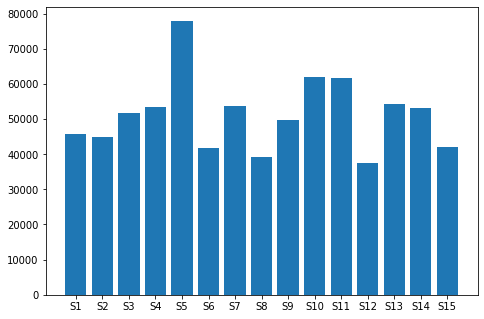

In [18]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(keys,sum_rpeaks)
plt.show()

### Link age to sum of chest mouvements on X axis

In [40]:
ages = []
sums = []
for i in range(len(dfs)):
    ages.append(dfs[i]["Age"][0])
    sums.append(dfs[i]["SUM_chest_ACC_X"].iloc[-1])

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0

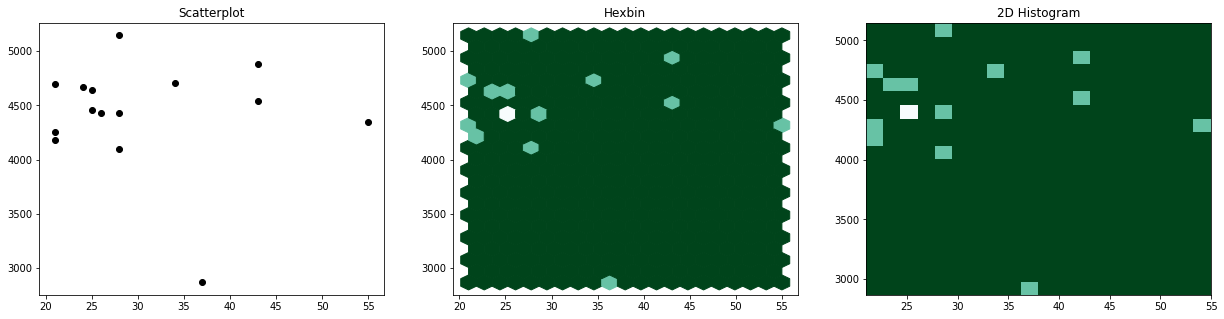

In [44]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(21, 5))
axes[0].set_title('Scatterplot')
axes[0].plot(ages, sums, 'ko')

# Thus we can cut the plotting window in several hexbins
nbins = 20
axes[1].set_title('Hexbin')
axes[1].hexbin(ages, sums, gridsize=nbins, cmap=plt.cm.BuGn_r)
 
# 2D Histogram
axes[2].set_title('2D Histogram')
axes[2].hist2d(ages, sums, bins=nbins, cmap=plt.cm.BuGn_r)

### Correlation matrix

In [11]:
corr = dataframe.corr()

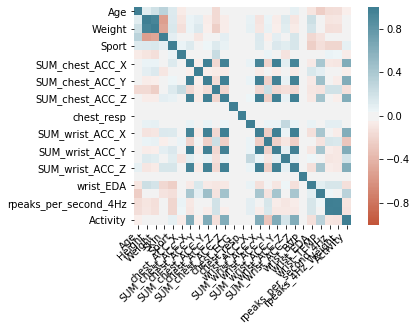

In [12]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### K means

In [17]:
kmeans = KMeans(n_clusters=9, random_state=0).fit(X)

In [18]:
kmeans.labels_

array([5, 5, 5, ..., 7, 7, 7])

In [19]:
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8}

## Build models

In [13]:
X = dataframe.iloc[:,0:25]
y = dataframe['Activity']

### Encode values

In [14]:
cat_cols = ['Gender']
for col in cat_cols:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(X[col].values.astype('str')))
    X[col] = lbl.transform(list(X[col].values.astype('str')))

In [15]:
X

,Gender,Age,Height,Weight,Skin,Sport,chest_ACC_X,SUM_chest_ACC_X,chest_ACC_Y,SUM_chest_ACC_Y,chest_ACC_Z,SUM_chest_ACC_Z,chest_ECG,chest_resp,wrist_ACC_X,SUM_wrist_ACC_X,wrist_ACC_Y,SUM_wrist_ACC_Y,wrist_ACC_Z,SUM_wrist_ACC_Z,wrist_BVP,wrist_EDA,wrist_TEMP,rpeaks_per_second_4Hz,rpeaks_4Hz_Weight
0,1,34,182.0,78.0,3,6,0.8564,0.856400,-0.0678,0.067800,-0.3656,0.365600,0.015610,4.441833,-0.765625,0.765625,-0.078125,0.078125,0.671875,0.671875,7.28,4.722437,32.13,1,2
1,1,34,182.0,78.0,3,6,0.8514,0.861400,-0.0654,0.070200,-0.3688,0.368800,-0.015747,4.876709,-0.765625,0.765625,-0.078125,0.078125,0.671875,0.671875,-11.36,4.728843,32.16,1,2
2,1,34,182.0,78.0,3,6,0.8514,0.861400,-0.0662,0.071000,-0.3708,0.370800,-0.008743,3.340149,-0.765625,0.765625,-0.078125,0.078125,0.671875,0.671875,-51.27,4.718594,32.16,1,2
3,1,34,182.0,78.0,3,6,0.8594,0.869400,-0.0632,0.074000,-0.3640,0.377600,-0.339523,0.740051,-0.750000,0.781250,-0.078125,0.078125,0.671875,0.671875,5.65,4.717312,32.16,1,2
4,1,34,182.0,78.0,3,6,0.8510,0.877800,-0.0674,0.078200,-0.3694,0.383000,-0.089905,-1.475525,-0.765625,0.796875,-0.078125,0.078125,0.671875,0.671875,34.34,4.713469,32.16,1,2
5,1,34,182.0,78.0,3,6,0.8508,0.878000,-0.0676,0.078400,-0.3646,0.387800,0.004349,-1.942444,-0.750000,0.812500,-0.078125,0.078125,0.671875,0.671875,14.96,4.712188,32.15,1,2
6,1,34,182.0,78.0,3,6,0.8666,0.893800,-0.0626,0.083400,-0.3588,0.393600,0.103592,-0.576782,-0.765625,0.828125,-0.078125,0.078125,0.671875,0.671875,-1.47,4.716032,32.15,1,2
7,1,34,182.0,78.0,3,6,0.8190,0.941400,-0.0598,0.086200,-0.3536,0.398800,-0.166672,1.838684,-0.765625,0.828125,-0.062500,0.093750,0.687500,0.687500,-40.06,4.704501,32.15,1,2
8,1,34,182.0,78.0,3,6,0.8520,0.974400,-0.0666,0.093000,-0.3826,0.427800,0.159714,2.915955,-0.750000,0.843750,-0.078125,0.109375,0.671875,0.703125,6.34,4.698095,32.15,0,1
9,1,34,182.0,78.0,3,6,0.8506,0.975800,-0.0606,0.099000,-0.3870,0.432200,-0.129089,1.408386,-0.750000,0.843750,-0.078125,0.109375,0.671875,0.703125,33.27,4.700657,32.15,0,1


### Split Datas

In [16]:
X_train, X_testing, y_train, y_testing = train_test_split(X, y, test_size=0.20, random_state=42)

### Decision Tree

In [40]:
dec_tree = tree.DecisionTreeClassifier()
dec_tree = dec_tree.fit(X_train, y_train)

[Text(185.6223994953495, 215.34923076923076, 'X[7] <= 2774.298\nentropy = 0.837\nsamples = 414364\nvalue = [112484, 29248, 20711, 14922, 22211, 43641, 86718, 30110\n54319]'),
 Text(77.65835494816436, 211.1676923076923, 'X[7] <= 55.002\nentropy = 0.763\nsamples = 213885\nvalue = [84294, 29248, 20711, 14922, 22211, 41805, 694, 0, 0]'),
 Text(13.371035968295466, 206.98615384615385, 'X[7] <= 9.347\nentropy = 0.34\nsamples = 37266\nvalue = [8095, 29171, 0, 0, 0, 0, 0, 0, 0]'),
 Text(10.212090649434689, 202.80461538461537, 'X[19] <= 38.383\nentropy = 0.016\nsamples = 3118\nvalue = [3093, 25, 0, 0, 0, 0, 0, 0, 0]'),
 Text(10.056613865456722, 198.62307692307692, 'X[15] <= 28.898\nentropy = 0.009\nsamples = 3107\nvalue = [3093, 14, 0, 0, 0, 0, 0, 0, 0]'),
 Text(9.901137081478755, 194.44153846153847, 'entropy = 0.0\nsamples = 3040\nvalue = [3040, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(10.212090649434689, 194.44153846153847, 'X[11] <= 10.459\nentropy = 0.331\nsamples = 67\nvalue = [53, 14, 0, 0, 0, 0, 

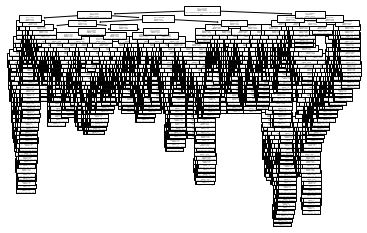

In [41]:
tree.plot_tree(dec_tree) 

In [68]:
tree_prediction = dec_tree.predict(X_testing)
tree_accuracy = accuracy_score(y_testing, tree_prediction)
tree_accuracy

0.9941597806780447

In [73]:
tree_recall = recall_score(y_testing, tree_prediction, average='macro')
tree_recall

0.9939843563473727

In [74]:
confusion_matrix(y_testing, tree_prediction)

array([[27550,    28,     9,    35,    89,    56,    25,    18,    38],
       [   16,  7316,     0,     0,     0,     0,     0,     0,     0],
       [   11,     0,  5226,     4,     0,     0,     0,     0,     0],
       [   35,     0,     4,  3555,     0,     0,     0,     0,     0],
       [   78,     0,     0,     0,  5542,     1,     0,     0,     0],
       [   66,     0,     0,     0,     0, 11041,     0,     0,     0],
       [   20,     0,     0,     0,     0,     0, 21659,    15,     0],
       [    9,     0,     0,     0,     0,     0,    14,  7425,     6],
       [   27,     0,     0,     0,     0,     0,     0,     1, 13673]],
      dtype=int64)

In [77]:
filename = 'decision_tree_model.sav'
pickle.dump(dec_tree, open(filename, 'wb'))

### Random Forest

In [20]:
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [21]:
prediction = rf.predict(X_testing)

In [22]:
accuracy = accuracy_score(y_testing, prediction)
accuracy

0.9992373928488686

In [75]:
forest_recall = recall_score(y_testing, prediction, average='macro')
forest_recall

0.9991658610056393

In [28]:
confusion_matrix(y_testing, prediction)

array([[27807,     3,     4,     2,    11,     4,     9,     6,     2],
       [    4,  7328,     0,     0,     0,     0,     0,     0,     0],
       [    4,     0,  5237,     0,     0,     0,     0,     0,     0],
       [    5,     0,     0,  3589,     0,     0,     0,     0,     0],
       [   14,     0,     0,     0,  5607,     0,     0,     0,     0],
       [    2,     0,     0,     0,     0, 11105,     0,     0,     0],
       [    2,     0,     0,     0,     0,     0, 21692,     0,     0],
       [    1,     0,     0,     0,     0,     0,     0,  7453,     0],
       [    6,     0,     0,     0,     0,     0,     0,     0, 13695]],
      dtype=int64)

In [78]:
filename = 'random_forest_model.sav'
pickle.dump(rf, open(filename, 'wb'))

### XGBoost

In [79]:
xg_class = XGBClassifier(objective ='reg:linear', eta = 0.3,
                       colsample_bytree = 0.3, learning_rate = 0.1, 
                       max_depth = 10, alpha = 10, n_estimators = 100, 
                       subsample=0.7)
xg_class.fit(X_train,y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eta=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [80]:
prediction_xgb = xg_class.predict(X_testing)

In [81]:
accuracy_xgb = accuracy_score(y_testing, prediction_xgb)
accuracy_xgb

0.9992953123793343

In [82]:
xgb_recall = recall_score(y_testing, prediction_xgb, average='macro')
xgb_recall

0.9992932864082934

In [83]:
confusion_matrix(y_testing, prediction_xgb)

array([[27805,     3,     6,     2,     6,     4,    11,     9,     2],
       [    2,  7330,     0,     0,     0,     0,     0,     0,     0],
       [    6,     0,  5235,     0,     0,     0,     0,     0,     0],
       [    7,     0,     0,  3587,     0,     0,     0,     0,     0],
       [    3,     0,     0,     0,  5618,     0,     0,     0,     0],
       [    2,     0,     0,     0,     0, 11105,     0,     0,     0],
       [    2,     0,     0,     0,     0,     0, 21692,     0,     0],
       [    1,     0,     0,     0,     0,     0,     0,  7453,     0],
       [    7,     0,     0,     0,     0,     0,     0,     0, 13694]],
      dtype=int64)

In [84]:
filename = 'xgb_model.sav'
pickle.dump(xg_class, open(filename, 'wb'))